# Using CorrelationConnection

## Preliminaries

First of all, follow the instructions on README.md to install the software and activate the right Conda enviornment. Once that has been done, you can launch this Jupyter Notebook. 

Load necessary libraries:

In [1]:
import pickle
import sys
sys.path.append("./bin/")
sys.path.append(".")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Tell your system where it can find executables:

In [2]:
sys.path.append("../../CorrelationConnection/bin/")

The line above may change depending on your working directory. The exact way it is written above works if your working directory is a subfolder of ```CorrelationConnection``` (e.g. ```CorrelationConnection/docs```) and ```CorrelationConnection``` contains another sub-folder called ```bin``` containing the files ```exact_diagonalisation_code.py```, ```exact_diagonalisation_code_sparse.py```, etc.

Import some more libraries:

In [3]:
import scipy 
import scipy.sparse.linalg as sprsla
from hamiltonians import NNHamiltonian
from randomizer import RandomizerHamiltonianNNRandomDelta, RandomizerStateRandomDelta
from stability_analysis_class import StabilityAnalysisSparse
from tools import SijCalculator
from exact_diagonalisation_code_sparse import create_sx_sparse, create_sy_sparse, create_sz_sparse
from math import sqrt, pi

## Generating data

Let's now get started with the generation of some data from scratch. We will focus on quantum tomography in the ground state as an example.

**TO DO:**
* **We must include in this tutorial Hamiltonian learning 
examples as well, and also finite-temperature examples of both.**

### Creating a Hamiltonian

To begin, we will create a Hamiltonian object for ```L``` sites with interactions up to next nearest neighbours at temperature ```temp=0```. This is achieved with the class ```NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)```. To keep things simple we will make the system a dimer and we will not apply a magnetic field: 

In [291]:
# 1) SET VALUES FOR INPUTS:

L=2                                        # <-- Dimer
h = [[0, 0, 0]]                            # <-- No applied field
J_onsite = np.zeros((3, 3))                # <-- No onsite interactions (superfluous anyway)
J_nnn = np.zeros((3, 3))                   # <-- No nnn interactions
J_nn = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]   # <-- Diagonal nn interactions

# 2) CREATE THE HAMILTONIAN: 

HAMILTONIAN = NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)

```NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)``` is one of three classes of Hamiltonians.  The others can be found in ```bin/hamiltonians.py```. 

Note that the object is not just the Hamiltonian. It includes the temperature as well. The Hamiltonian itself can be extracted using ```get_init_ham()```:

In [292]:
H=HAMILTONIAN.get_init_ham()

The Hamiltonian ```H``` is not an array, it is a sparse matrix object (from ```scipy.sparse```). Therefore, only the matrix elements that are non zero are stored. If we try to print ```H``` we will get a list of its non-zero elements:

In [293]:
print(H)

  (0, 0)	(0.5+0j)
  (1, 1)	(-0.5+0j)
  (1, 2)	(1+0j)
  (2, 1)	(1+0j)
  (2, 2)	(-0.5+0j)
  (3, 3)	(0.5+0j)


Note the factor of "2" in the definition of the Hamilonian.

Let us now find the ground-state energy and state vector:

In [294]:
GROUND_STATE=SijCalculator.find_gs_sparse(H)
print("Ground state energy = ",GROUND_STATE[0],"\nGround state vector = \n",np.round(GROUND_STATE[1],2))

Ground state energy =  [-1.5] 
Ground state vector = 
 [[-0.  +0.j  ]
 [ 0.65-0.27j]
 [-0.65+0.27j]
 [-0.  +0.j  ]]


Note that we have used np.round to write the grounds state with only 2 decimal points for clarity.

We can also work with a dense-matrix representation:

In [295]:
H_DENSE=H.todense()

In [296]:
print(H_DENSE)

[[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5+0.j]]


```find_eigvals``` can now be used to find all the energies:

In [297]:
ENERGIES = SijCalculator.find_eigvals(H_DENSE)

In [298]:
print(ENERGIES)

[ 0.5+0.j -1.5+0.j  0.5+0.j  0.5+0.j]


### Generating fitness landscape data

Now we can carry out the fitness landscape analysis. 

In order to do this we need to set a few parameters that specifiy the type of fitness landscape we want to explore and how.

First, we need to set up a randomizer. There are several available, they are all in ```randomizer.py```. Here we use ```RandomizerStateRandomDelta``` which creates random state vectors the real and imaginary parts of whose amplitudes are picked from a flat probability distribution centred on those of a given input state. 

In [299]:
delta= 0.5
no_of_processes= 64 
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

Now, set up our exploration of the fitness landscape using ```StabilityAnalysisSparse``` from ```stability_analysis_class.py```: 

In [300]:
corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

In [301]:
STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

Finally, we generate the data by using ```generate_random_Sij_sparse``` which is found in ```stability_analysis_class.py```:

In [302]:
no_of_samples= 5
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

The output is a list of 8 objects so instead of storing it in a single variable we have directly stored it in 8 conevniently-named variables. Let us now see what each of them contains.

```dist``` contains the distances of the random states to the ground state of the reference Hamiltonian:

In [303]:
dist

[2.519841246773069e-06,
 0.05367376078786812,
 0.09804832162905242,
 0.012902543599746186,
 0.027267703620705963]

```en``` contains the corresponding ground state energies:

In [304]:
print(en)

[array([5.03968249e-06+1.11022302e-16j]), array([0.10734752+0.j]), array([0.19609664+0.j]), array([0.02580509+0.j]), array([0.05453541+1.11022302e-16j])]


```diffSij``` contains the distances between real-space correlators:

In [305]:
diffSij

[8.81889324129901e-05,
 0.01287088790713802,
 0.017395927012748662,
 0.0063105202187549725,
 0.009173853011480694]

```Sqs``` contains the reciprocal space expressions of all the random correlators, computed on a $100 \times 100$ grid in $\mathbf{q}$-space. In other words, these are the spin-resovled diffuse, magnetic neutron scattering functions. To be more explicit, let 

$\rho_{i,j}^{\alpha,\beta}\left[\psi_n^{\rm rand}\right] 
\equiv 
\left\langle 
    \psi_n^{\rm rand} 
    \left| 
        S_i^{\alpha} S_j^{\beta} 
    \right|
    \psi_n^{\rm rand}
\right\rangle$ 

represent the correlator between the component $\alpha$ of the spin at site $i$ and the component $\beta$ of the spin at site $j$ ($\alpha,\beta=x,y,z$; $i,j=0,1,\ldots,L-1$). We define the reciprocal of this quantity (up to a normalisation constant) as 

$\mathcal{S}_{\alpha,\beta}^n(\mathbf{q})
\equiv 
\sum_{i,j=0}^{L-1}e^{i\mathbf{q}.(\mathbf{R}_i-\mathbf{R}_j)}\rho_{i,j}^{\alpha,\beta}\left[\psi_n^{\rm rand}\right] $

Note that this is not the same as a Fourier transform, as the quantity $\rho_{i,j}^{\alpha,\beta}\left[\psi_n^{\rm rand}\right]$ does not depend only on $\mathbf{R}_i-\mathbf{R}_j$ but in general depends on $\mathbf{R}_i$ and $\mathbf{R}_j$ independently. Indeed, this will be the case for a magnetic molecule sitting somewhere in space, since the structure is not periodic in this case. For the same reason, the vector $\mathbf{q}$ is not restricted to a discretised lattice. It represents the momentum transferred between the sample and the neutron, which can vary continuously. In the code we discretise the values of the two-dimensional vactor $\mathbf{q}=(q_x,q_y)$ by allowing 100 values of $q_x$ and 100 values of $q_y$, each uniformly distributed between $-2\pi$ and $+2\pi$ (giving 10000 values of the wave vector $\mathbf{q}$ in total).

**TO DO:**
* **The code must be generalised (and then documented here) to make it possible to change how fine the q-grid is and also to extend the q values further out e.g. to $10\pi$ or, conversely, focusing on a smaller part of q-space. This is important, for example in a big molecule what happens at long distances influences a small region of q-space ner the origin.**
* **Throughout this tutorial we give the formulae for sums and integrals without their normalisation factors. We must document here those.**

The structure of ```Sqs``` is best illustrated through a couple of  examples. For instance, in our case, 

```Sqs[3]["Sxy"][23][76]``` 

contains the value of $\mathcal{S}_{x,y}^3(\mathbf{q})$ at a wave vector $\mathbf{q}$ given by the coordinates $(23,76)$ on our discretised reciproclal grid:

In [306]:
print(Sqs[3]["Sxy"][23][76])

(0.0009401415812348712-0.010307534655461567j)


Similarly 

```Sqs[2]["Syy"][10][35]``` 

contains the value of  $\mathcal{S}_{y,y}^2(\mathbf{q})$ at a wave vector $\mathbf{q}$ given by the coordinates $(10,35)$:

In [307]:
print(Sqs[2]["Syy"][10][35])

(0.18992044189645935+0j)


Note that the $xy$ correlator is a complex number, while the $yy$ correlator is real. This makes sense: $\mathcal{S}_{\alpha,\beta}^n(\mathbf{q})$ is not the expectation value of a Hermitian operator, and in general the sum over $i$ and $j$ will have terms of the form 

$\left\langle 
    \psi_n^{\rm rand} 
    \left|  
    S_i^{\alpha} S_j^{\beta}
 \right|
    \psi_n^{\rm rand}
\right\rangle
e^{i.(\mathbf{R}_i-\mathbf{R}_j)}
+
\left\langle 
    \psi_n^{\rm rand} 
    \left| 
    S_i^{\beta} S_j^{\alpha}
\right|
    \psi_n^{\rm rand}
\right\rangle
e^{-i.(\mathbf{R}_i-\mathbf{R}_j)}$

The two expectation values are both real but in general they are different, and therefore the imaginary parts of the two exponentials do not cancel. For $\alpha=\beta$, they do.

```Sijs``` contains the values of real-space correlators, for instance ```Sijs[3]['Sxz'][0][1]``` is the value of the $xz$ correlator betweent the 1st site and the 2nd site in the 3rd random state, 
$\left\langle 
    \psi_3^{\rm rand} 
    \left| 
        S_0^{x} S_1^{z} 
    \right|
    \psi_3^{\rm rand}
\right\rangle$:

In [308]:
Sijs[3]['Sxz'][0][1]

(-0.012963672259959499+4.336808689942018e-19j)

```Sqints``` contains the diffuse magnetic neutron scattering functions for each fo the random ground states, computed by combining the individual spin-resolved functions $\mathcal{S}_{\alpha,\beta}\left(\mathbf{q}\right)$ using the formula (up to a normalisation factor)

$    \mathcal{S}(\mathbf{q})
    =
    \sum_{\alpha.\beta}
    \left(
        \delta_{\alpha,\beta}-\hat{\mathbf{q}}_{\alpha}\hat{\mathbf{q}}_{\beta}
    \right)
    \mathcal{S}_{\alpha,\beta}(\mathbf{q}).$
    
Thus for instance ```Sqints[2][10][35]``` is the value of $\mathcal{S}\left(\mathbf{q}\right)$ for the 3rd random state (remember that random states are numbers $n=0,1,2,3,\ldots$) evaluated at the 10th values of $q_x$ and the 35th value of $q_y$:

In [309]:
Sqints[2][10][35]

0.500940027707721

Finally, ```Sq_int``` is the distance between the scattering functions $S'\left(\mathbf{q}\right)$ of a random state and its value $S'\left(\mathbf{q}\right)$ for the ground state of the reference Hamiltonian, evaluated using 

$    \Delta \mathcal{S} =  \int d\mathbf{q} \left[\mathcal{S}(\mathbf{q}) - \mathcal{S}'(\mathbf{q})\right]^2.$

```Sq_int[n]``` is the value of this quantity for the $n^{\rm th}$ random state:

In [310]:
Sq_int

[4.883561971139722e-10,
 0.2259120167397237,
 1.0030461853532668,
 0.05809720868861704,
 0.3210851458082222]

We can see that there is a correlation between how close the scattering functions were and how close the states were: 

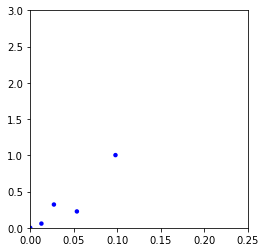

In [311]:
fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

plt.xlim(0,0.25)
plt.ylim(0,3)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(0.25/3) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

We can see that there's a correlation, with the states that are closer to the ground state of the reference Hamiltonian generally having smaller ```Sq_int```.

It is illustrative to display the $\mathcal{S}(\mathbf{q})$ for each fo the random states:

0 th random state, dist= 2.519841246773069e-06 Sq_int= 4.883561971139722e-10 :


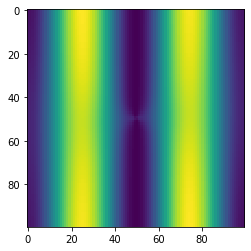

1 th random state, dist= 0.05367376078786812 Sq_int= 0.2259120167397237 :


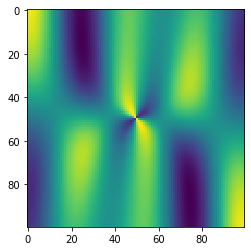

2 th random state, dist= 0.09804832162905242 Sq_int= 1.0030461853532668 :


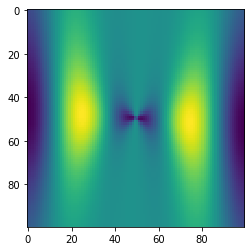

3 th random state, dist= 0.012902543599746186 Sq_int= 0.05809720868861704 :


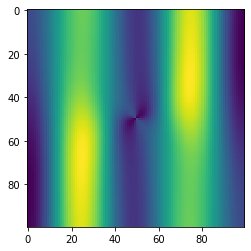

4 th random state, dist= 0.027267703620705963 Sq_int= 0.3210851458082222 :


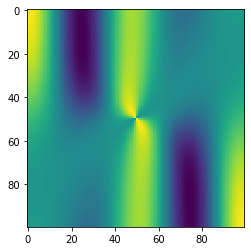

In [312]:
for n in range(no_of_samples):
    print(n,"th random state, dist=",dist[n],"Sq_int=",Sq_int[n],":")
    plt.imshow(Sqints[n])
    plt.show()

So we can see that the different random states generate very different scattering functions. 

Here with many more data points (```no_of_samples= 5``` $\to$ ```1000```) and wider variation of random states (```delta= 0.5``` $\to$ ```3```):

In [228]:
delta= 3
no_of_processes= 64
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

no_of_samples= 1000
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=EXAMPLE=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

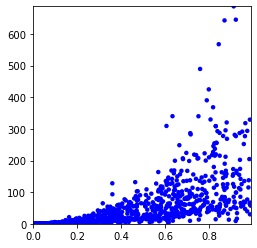

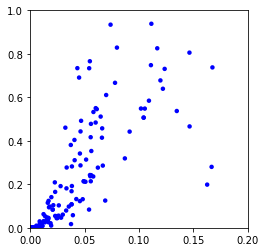

In [229]:
fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

max_dist=max(dist)
max_Sq_int=max(Sq_int)

#max_dist=max_dist/10
#max_Sq_int=max_Sq_int/100

plt.xlim(0,max_dist)
plt.ylim(0,max_Sq_int)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(max_dist/max_Sq_int) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

maxx=0.2
maxy=1
plt.xlim(0,maxx)
plt.ylim(0,maxy)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(maxx/maxy) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

Here is another example with L=4 spins in the molecule, where we put everything in one cell for easy re-use (the cell takes about 20 seconds to run on a ThinkPad P1 Gen2 Workstation Laptop):

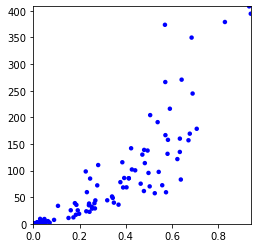

In [232]:
# 1) SET VALUES FOR INPUTS:

L=4                                        # <-- Number of sites
h = [[0, 0, 0]]                            # <-- No applied field
J_onsite = np.zeros((3, 3))                # <-- No onsite interactions (superfluous anyway)
J_nnn = np.zeros((3, 3))                   # <-- No nnn interactions
J_nn = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]   # <-- Diagonal nn interactions

# 2) CREATE THE HAMILTONIAN: 

HAMILTONIAN = NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)

# 3) SET UP THE RANDOMIZER:

delta= 1
no_of_processes= 64
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

# 4) SET UP THE FITNESS LANDSCAPE ANALYSIS:

corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

# 5) CARRY OUT THE CALCULATIONS:

no_of_samples= 100
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=EXAMPLE=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

# 6) MAKE THE PLOT:

fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

max_dist=max(dist)
max_Sq_int=max(Sq_int)

#max_dist=max_dist/10
#max_Sq_int=max_Sq_int/10

plt.xlim(0,max_dist)
plt.ylim(0,max_Sq_int)
#ax.legend('sssx') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(max_dist/max_Sq_int) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

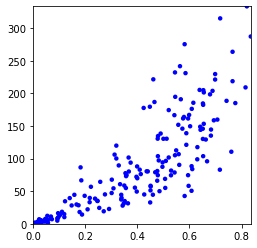

In [231]:
# 1) SET VALUES FOR INPUTS:

L=4                                        # <-- Number of sites
h = [[0, 0, 0]]                            # <-- No applied field
J_onsite = np.zeros((3, 3))                # <-- No onsite interactions (superfluous anyway)
J_nnn = np.zeros((3, 3))                   # <-- No nnn interactions
J_nn = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]   # <-- Diagonal nn interactions

# 2) CREATE THE HAMILTONIAN: 

HAMILTONIAN = NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)

# 3) SET UP THE RANDOMIZER:

delta= 1
no_of_processes= 64
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

# 4) SET UP THE FITNESS LANDSCAPE ANALYSIS:

corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

# 5) CARRY OUT THE CALCULATIONS:

no_of_samples= 200
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=EXAMPLE=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

# 6) MAKE THE PLOT:

fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

max_dist=max(dist)
max_Sq_int=max(Sq_int)

#max_dist=max_dist/10
#max_Sq_int=max_Sq_int/10

plt.xlim(0,max_dist)
plt.ylim(0,max_Sq_int)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(max_dist/max_Sq_int) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

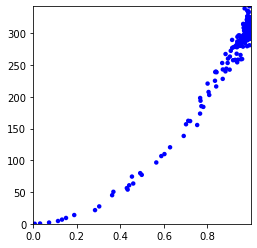

In [242]:
# 1) SET VALUES FOR INPUTS:

L=8                                        # <-- Number of sites
h = [[0, 0, 0]]                            # <-- No applied field
J_onsite = np.zeros((3, 3))                # <-- No onsite interactions (superfluous anyway)
J_nnn = np.zeros((3, 3))                   # <-- No nnn interactions
J_nn = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]   # <-- Diagonal nn interactions

# 2) CREATE THE HAMILTONIAN: 

HAMILTONIAN = NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)

# 3) SET UP THE RANDOMIZER:

delta= 2
no_of_processes= 64
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

# 4) SET UP THE FITNESS LANDSCAPE ANALYSIS:

corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

# 5) CARRY OUT THE CALCULATIONS:

no_of_samples= 200
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=EXAMPLE=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

# 6) MAKE THE PLOT:

fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

max_dist=max(dist)
max_Sq_int=max(Sq_int)

#max_dist=max_dist/10
#max_Sq_int=max_Sq_int/10

plt.xlim(0,max_dist)
plt.ylim(0,max_Sq_int)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(max_dist/max_Sq_int) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()

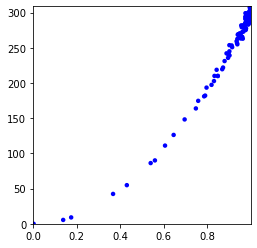

In [243]:
# 1) SET VALUES FOR INPUTS:

L=10                                        # <-- Number of sites
h = [[0, 0, 0]]                            # <-- No applied field
J_onsite = np.zeros((3, 3))                # <-- No onsite interactions (superfluous anyway)
J_nnn = np.zeros((3, 3))                   # <-- No nnn interactions
J_nn = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]   # <-- Diagonal nn interactions

# 2) CREATE THE HAMILTONIAN: 

HAMILTONIAN = NNHamiltonian(L, h, J_onsite, J_nn, J_nnn, temp=0)

# 3) SET UP THE RANDOMIZER:

delta= 2
no_of_processes= 64
RANDOMIZER = RandomizerStateRandomDelta(HAMILTONIAN, delta, no_of_processes)

# 4) SET UP THE FITNESS LANDSCAPE ANALYSIS:

corr = ["Sxx", "Sxy", "Sxz", "Syx", "Syy", "Syz", "Szx", "Szy", "Szz"]
temp= HAMILTONIAN.temp  # <-- Obtain temperature from the Hamiltonian setup
save_rhams= "False"     # <-- Do not save random Hamiltonians/states
temp_type= "value"      # <-- Temperature given explicitly

STABILITY_ANALYSIS = StabilityAnalysisSparse(HAMILTONIAN, RANDOMIZER, corr, save_rhams,temp_mul=temp, temp_type=temp_type)

# 5) CARRY OUT THE CALCULATIONS:

no_of_samples= 200
dist, en, diffSij, diffSq, Sqs, Sijs, Sqints, Sq_int=EXAMPLE=STABILITY_ANALYSIS.generate_random_Sij_sparse(no_of_samples)

# 6) MAKE THE PLOT:

fig, ax = plt.subplots()

scale = 20 # size of dots

x, y = dist,Sq_int  
ax.scatter(x, y, c='blue', s=scale, label='A plot',alpha=1.0, edgecolors='none')

max_dist=max(dist)
max_Sq_int=max(Sq_int)

#max_dist=max_dist/10
#max_Sq_int=max_Sq_int/10

plt.xlim(0,max_dist)
plt.ylim(0,max_Sq_int)
#ax.legend('sss') 

ax.grid(False) # True = grid displayed ; False = no grid displayed

ax.set_aspect(max_dist/max_Sq_int) # Use lengths of xlim and ylim for a square plot

plt.savefig('filename.png', dpi=300) # Export hires figure

plt.show()